# Data retrieval, elaboration and visualization
In this lesson we will start by retrieving epigenomic data from [ENCODE](https://www.encodeproject.org/) and genomic sequence data from [UCSC genome browser](https://genome.ucsc.edu/). After learning how to retrieve and elaborate these data, we will focus on elaboration of epigenomic data (specifically the recently obtained CIS-regulatory regions data) with the imputation of NaN values and linear and non-linear correlation tests for automatic feature selection. 

After visualizing the discrete features distributions using binning, we will run the TSNE and PCA decompositions of the data.

This lesson is written with the goal of illustrating an useful set of tools that you might very likely use on almost every project of machine learning you will ever tackle.

In [1]:
from tqdm.auto import tqdm # A simple loading bar
import matplotlib.pyplot as plt # A standard plotting library
import pandas as pd
import numpy as np
from multiprocessing import cpu_count
from glob import glob 
import seaborn as sns

## Just a bit of theoretical background
In this mainly computer science-focused lesson we will touch upon some biology-related terms. Don't be weary! Let's start by facing them head-first so that they might be out of the way.

### What are Cis-regulatory regions?
CRRs, through interactions with proteins and transcription factors, help specify the formation of diverse cell types and to respond to changing physiological conditions. Deciphering the active CRRs in each cell type is a  fundamental step to uncover the misregulations underlying numerous human genetic disease and cancers.

![Cis-Regulatory regions](https://github.com/LucaCappelletti94/bioinformatics_practice/blob/master/Notebooks/arr.png?raw=true)

## Data retrieval
Data Retrieval is a process of identifying and extracting data from the database that is based on a query which is provided by the user. It is a foundamental aspect of every experimental setup, as making sure that the data required to replicate the experiment are easily accessible is a stepping stone of good science.

In this section, assuming you have [already learned how to make query from ENCODE from this other lesson](https://github.com/LucaCappelletti94/bioinformatics_practice/blob/master/Notebooks/Retrieving%20data%20from%20ENCODE%20-%20Practical%20example.ipynb), genomic sequences from [UCSC genomic browser](https://genome.ucsc.edu/) and CAGE labels for cis-regulatory regions from [FANTOM5](https://fantom.gsc.riken.jp/).

### FANTOM5
FANTOM (Functional ANnoTation Of the Mammalian genome) is a worldwide collaborative project aiming at identifying all functional elements in mammalian genomes. It started at RIKEN Yokohama, as a part of mouse encyclopedia project in Japan (see its history). In 2014, FANTOM5 unraveled the biggest collection of promoters across a wide range of samples.

We are going to retrieve those promoters, alongside the still considerable collection of enhancers.

To do this we are going to use [crr_labels](https://github.com/LucaCappelletti94/crr_labels), a python package that automates the retrieval and sanitization of these data.

In this lesson we are skipping how these data are sanitized, but it is explained step by step [within the repository README if you were curious or in need of clarifications](https://github.com/LucaCappelletti94/crr_labels).

We will choose a window size for our genomic regions (the width of the window of nucleotides we are going to take in consideration): we will use a window of 200 nucleotides.

In [2]:
window_size = 256

In [70]:
from crr_labels import fantom

cell_line="K562"
assembly="hg38"

enhancers, promoters = fantom(
    cell_lines=[cell_line], # list of cell lines to be considered.
    window_size=window_size, # window size to use for the various regions.
    genome = assembly, # considered genome version. Currently supported only "hg19".
    center_enhancers = "peak", # how to center the enhancer window, either around "peak" or the "center" of the region.
    enhancers_threshold = 0, # activation threshold for the enhancers.
    promoters_threshold = 5, # activation threshold for the promoters.
    drop_always_inactive_rows = False, # whetever to drop the rows where no activation is detected for every rows.
    binarize = True, # Whetever to return the data binary-encoded, zero for inactive, one for active.
)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3319: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Let's now take a look to how the labels we have downloaded look like!

Here we will look at the first 5 labels.

In [71]:
promoters[:5]

,chrom,chromStart,chromEnd,strand,K562
0,chr1,564344,564600,+,0
1,chr1,564393,564649,+,0
2,chr1,565022,565278,+,0
3,chr1,565227,565483,+,0
4,chr1,565285,565541,+,0


The obtained [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) containing the labels has the structure of a simple [BED file format](https://genome.ucsc.edu/FAQ/FAQformat.html#format1).

The first 4 columns are the coordinates of the region, while the last one is the label (one for active, zero for inactive).

The first column, **chrom**, is the [chromosome](https://en.wikipedia.org/wiki/Chromosome), the second one **chromStart** is the start of the genomic region, the third one **chromEnd** is the end of region and finally **strand** is the [sense of reading of the genomic sequence](https://en.wikipedia.org/wiki/Sense_(molecular_biology)), whetever the positive strand of the helix of the negative strand.

We can save the dataframe to a bed file (which is a [tab separated file](https://en.wikipedia.org/wiki/Tab-separated_values)), so to be able to query our BigWig file, as follows:

In [5]:
bed_file_path = "promoters.bed"

promoters[promoters.columns[:4]].to_csv(
    bed_file_path, # The path where to save the file.
    sep="\t", # The file separator, in this case a tab.
    header=False # We have to remove the schema of the file, since we are going to use bwtool on this.
)

Since pybwtool is based on [bwtool](https://github.com/CRG-Barcelona/bwtool) that is only available for [Linux systems](https://en.wikipedia.org/wiki/Linux) and the installation process can be a bit painful, I will show you how to proceed below but you can consider skipping to the next step as we will also make the complete data available [through a pipeline we have already created previously](https://github.com/LucaCappelletti94/epigenomic_dataset).

If you want to proceed still, do so by running [this bash script](https://raw.githubusercontent.com/LucaCappelletti94/pybwtool/master/install_bwtool.sh) and then installing, if you haven't already done so, [pybwtool](https://pypi.org/project/pybwtool/).

The whole procedure looks like the following three commands:

```bash
wget https://raw.githubusercontent.com/LucaCappelletti94/pybwtool/master/install_bwtool.sh
bash install_bwtool.sh
pip install pybwtool
```

### Epigenomic dataset
Fortunately for us, the hard work to retrieve the epigenomic data from ENCODE, retrieving the labels from FANTOM and querying the terabites of bigwig files has already been done! We can use [the epigenomic_dataset package](https://github.com/LucaCappelletti94/epigenomic_dataset) to automatically download the data and start working on them!

In [10]:
from epigenomic_dataset import load_epigenomes


promoters_epigenomes, promoters_labels = load_epigenomes(
    cell_line = cell_line,
    dataset = "fantom",
    region = "promoters",
    window_size = window_size
)

enhancers_epigenomes, enhancers_labels = load_epigenomes(
    cell_line = cell_line,
    dataset = "fantom",
    region = "enhancers",
    window_size = window_size
)

Let's take a look at the data!

In [11]:
promoters_epigenomes[:5]

chrom                             SMAD5  NCOA2  ZNF23  NR2F6  CEBPZ  SNIP1  \
chrom chromStart chromEnd strand                                             
chr1  628964     629220   +        0.14   1.00   0.19   1.01   0.60   0.38   
      629013     629269   +        0.14   0.97   0.20   0.89   0.43   0.43   
      629642     629898   +        0.00   0.11   0.11   0.06   0.00   0.10   
      629847     630103   +        0.12   1.07   0.91   0.41   0.60   0.73   
      629905     630161   +        0.49   1.37   1.02   0.41   0.60   0.92   

chrom                             ZBTB7A  ZNF133  NRF1  TAF1  ...  SIN3A  \
chrom chromStart chromEnd strand                              ...          
chr1  628964     629220   +          0.5    0.57  0.47  0.00  ...   0.28   
      629013     629269   +          0.5    0.53  0.45  0.00  ...   0.19   
      629642     629898   +          0.0    0.22  0.14  0.00  ...   0.11   
      629847     630103   +          0.0    1.25  0.63  0.07  ...   0.31   
      629905     630161   +          0.0    1.24  0.70  0.58  ...   0.57   

chrom                             SMARCC2  ZFP91  E2F4  NR3C1  SAFB2  E4F1  \
chrom chromStart chromEnd strand                                             
chr1  628964     629220   +          0.99   0.65  0.00   0.58   0.63  1.54   
      629013     629269   +          0.71   0.49  0.00   0.64   0.33  1.54   
      629642     629898   +          0.25   0.25  0.00   0.29   1.14  0.11   
      629847     630103   +          1.10   1.08  0.95   1.61   1.38  0.53   
      629905     630161   +          1.31   1.14  1.40   2.01   0.59  0.79   

chrom                             NCOR1  NCOA1  KLF1  
chrom chromStart chromEnd strand                      
chr1  628964     629220   +        1.40   1.74  1.59  
      629013     629269   +        1.42   1.63  1.21  
      629642     629898   +        0.00   0.16  0.09  
      629847     630103   +        0.40   0.60  0.88  
      629905     630161   +        0.54   0.61  1.15  

[5 rows x 429 columns]

As before for the labels, we have the usual BED file columns in our hands, plus lots of other weird looking columns names with float values.

Those gibberish looking columns, [for instance CEBPB](https://www.genecards.org/cgi-bin/carddisp.pl?gene=CEBPB), are the names of the genes that code for the proteins we are measuring the activation of.

The float values represent the amount of interaction measured in that specific region.

We have an extremely similar dataset also for the enhancers data:

In [12]:
enhancers_epigenomes[:5]

chrom                              SMAD5  NCOA2  ZNF23  NR2F6  CEBPZ  SNIP1  \
chrom chromStart chromEnd  strand                                             
chr10 100006381  100006637 .        0.90   0.90   1.37   0.67   0.58   1.19   
      100008146  100008402 .        0.73   1.06   0.74   0.42   0.61   0.81   
      100014418  100014674 .        0.77   0.33   0.53   0.58   0.82   1.98   
      100020216  100020472 .        0.87   0.80   0.83   0.63   0.82   0.94   
      100043528  100043784 .        0.64   0.53   0.03   0.60   0.99   0.22   

chrom                              ZBTB7A  ZNF133  NRF1  TAF1  ...  SIN3A  \
chrom chromStart chromEnd  strand                              ...          
chr10 100006381  100006637 .         0.79    0.86  1.22  0.00  ...   0.41   
      100008146  100008402 .         0.95    0.59  0.65  1.46  ...   0.94   
      100014418  100014674 .         0.15    0.99  0.85  0.51  ...   0.72   
      100020216  100020472 .         0.56    0.81  0.74  2.38  ...   0.74   
      100043528  100043784 .         0.28    0.55  0.69  2.04  ...   0.30   

chrom                              SMARCC2  ZFP91  E2F4  NR3C1  SAFB2  E4F1  \
chrom chromStart chromEnd  strand                                             
chr10 100006381  100006637 .          3.41   1.07  1.15   1.19   0.99  2.74   
      100008146  100008402 .          1.20   0.77  1.54   0.88   2.21  1.11   
      100014418  100014674 .          0.95   0.39  0.00   0.42   0.45  1.56   
      100020216  100020472 .          0.73   0.55  0.15   1.02   0.32  1.06   
      100043528  100043784 .          0.69   1.32  0.00   0.70   0.51  0.38   

chrom                              NCOR1  NCOA1  KLF1  
chrom chromStart chromEnd  strand                      
chr10 100006381  100006637 .        2.38   0.82  0.69  
      100008146  100008402 .        3.11   0.49  1.05  
      100014418  100014674 .        0.61   0.97  0.96  
      100020216  100020472 .        0.57   0.03  1.07  
      100043528  100043784 .        1.26   1.73  0.33  

[5 rows x 429 columns]

We are going to wrap these data in a dictionary for convenience:

In [13]:
epigenomes = {
    "promoters": promoters_epigenomes,
    "enhancers": enhancers_epigenomes
}

labels = {
    "promoters": promoters_labels,
    "enhancers": enhancers_labels
}

### Sequence data
After having retrieved epigenomic data we can retrieve the sequence data relative to the same BED regions.

We are going to use always the hg38 assembly as our reference genome.

#### UCSC Genomes Browser
The [UCSC Genome Browser](https://genome.ucsc.edu/index.html) is an on-line, and downloadable, genome browser hosted by the University of California, Santa Cruz (UCSC). It is an interactive website offering access to genome sequence data from a variety of vertebrate and invertebrate species and major model organisms, integrated with a large collection of aligned annotations.

We are going to use [UCSC genomes downloader](https://github.com/LucaCappelletti94/ucsc_genomes_downloader) to automatically download and elaborate the sequence data.

In [14]:
from ucsc_genomes_downloader import Genome

genome = Genome(assembly)

Loading chromosomes for genome hg38:   0%|          | 0/25 [00:00<?, ?it/s]

We can learn a couple informations about this genome just by printing it:

In [72]:
genome

Human, Homo sapiens, hg38, 2013-12-26, 25 chromosomes

In [73]:
print("The chromosomes in the human genome are: {}.".format(", ".join(genome)))

The chromosomes in the human genome are: chr1, chrM, chr21, chr22, chrY, chr19, chr20, chr18, chr17, chr16, chr15, chr14, chr13, chr12, chr10, chr11, chr9, chr8, chrX, chr7, chr6, chr5, chr4, chr3, chr2.


Now we can extract the bed coordinates from the promoters and enhancers data we have downloaded before:

In [74]:
def to_bed(data:pd.DataFrame)->pd.DataFrame:
    """Return bed coordinates from given dataset."""
    return data.reset_index()[data.index.names]

display(to_bed(epigenomes["promoters"])[:5])

chrom,chrom,chromStart,chromEnd,strand
0,chr1,628964,629220,+
1,chr1,629013,629269,+
2,chr1,629642,629898,+
3,chr1,629847,630103,+
4,chr1,629905,630161,+


We can use these coordinates to extract the nucleotides of these genomic regions as follows:

In [75]:
genome.bed_to_sequence(to_bed(epigenomes["promoters"])[:2])

array(['AAATGGTCATCCATCCTTTGGCCCCAATACCTAAACTAAGGTCTATGAACAATAAGATGATTTTCTTCAGTGGGACTTTTTTGTTTAATATATTAGATTTGACCTTCAGCAAGGTCAAAGGGAGTCCGAACTAGTCTCAGGCTTCAACATCGAATACGCCGCAGGCCCCTTCGCCCTATTCTTCATAGCCGAATACACAAACATTATTATAATAAACACCCTCACCACTACAATCTTCCTAGGAACAACATATAAC',
       'CAATAAGATGATTTTCTTCAGTGGGACTTTTTTGTTTAATATATTAGATTTGACCTTCAGCAAGGTCAAAGGGAGTCCGAACTAGTCTCAGGCTTCAACATCGAATACGCCGCAGGCCCCTTCGCCCTATTCTTCATAGCCGAATACACAAACATTATTATAATAAACACCCTCACCACTACAATCTTCCTAGGAACAACATATAACGCACTCTCCCCTGAACTCTACACAACATATTTTGTCACCAAGACCCTAC'],
      dtype='<U256')

Now we are going to extract the sequences and [one-hot encode](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/) them. With one-hot encoding we are referring to the procedure to encode every $i$-th class with the $2^i$ binary number, so to convert [categorical data](https://en.wikipedia.org/wiki/Categorical_variable) into a vector.

For doing this with nucleotides quickly we can use [keras_bed_sequence](https://github.com/LucaCappelletti94/keras_bed_sequence).

In [19]:
from keras_bed_sequence import BedSequence

def one_hot_encode(genome:Genome, data:pd.DataFrame, nucleotides:str="actg")->np.ndarray:
    return np.array(BedSequence(
        genome,
        bed=to_bed(data),
        nucleotides=nucleotides,
        batch_size=1
    ))

one_hot_encode(genome, epigenomes["promoters"][:2])

array([[[[0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         ...,
         [0., 0., 1., 0.],
         [1., 0., 0., 0.],
         [0., 1., 0., 0.]]],


       [[[1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         ...,
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 1., 0., 0.]]]])

But when we one-hot encode a categorical vector of $n$ samples and $4$ classes we obtain a matrix $n\times 4$. To be able to process the resulting matrix with the visualization tools we are going to consider in the third section of this lesson, we are going to flatten the matrix back to a longer vector.

In [20]:
def flat_one_hot_encode(genome:Genome, data:pd.DataFrame, window_size:int, nucleotides:str="actg")->np.ndarray:
    return one_hot_encode(genome, data, nucleotides).reshape(-1, window_size*4).astype(int)

flat_one_hot_encode(genome, epigenomes["promoters"][:2], window_size)

array([[0, 1, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 1, 0, 0]])

Finally, for easier use, we are going to convert back the one-hot encoded nucleotides into DataFrame:

In [21]:
def to_dataframe(x:np.ndarray, window_size:int, nucleotides:str="actg")->pd.DataFrame:
    return pd.DataFrame(
        x,
        columns = [
            f"{i}{nucleotide}"
            for i in range(window_size)
            for nucleotide in nucleotides
        ]
    )

Putting it all togheter we get:

In [22]:
sequences = {
    region: to_dataframe(
        flat_one_hot_encode(genome, data, window_size),
        window_size
    )
    for region, data in epigenomes.items()
}

So here's the flatten one-hot encoded sequences of our promoters and enhancers:

In [23]:
sequences["promoters"][:2]

,0a,0c,0t,0g,1a,1c,1t,1g,2a,2c,...,253t,253g,254a,254c,254t,254g,255a,255c,255t,255g
0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,1,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,1,1,0,0,0


In [24]:
sequences["enhancers"][:2]

,0a,0c,0t,0g,1a,1c,1t,1g,2a,2c,...,253t,253g,254a,254c,254t,254g,255a,255c,255t,255g
0,1,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


## Data elaboration
Finally after all that data retrieval and pre-processing we can finally move to some data elaboration.

In this section we will learn how to recognize and patch where possible common shortcomings in tabular datasets, such as an imbalance between classes, handling NaN values, features correlations and feature selection.

We will just touch upon these various subjects in a very applicative way, as every single of them would require an entire course to be dealt with the proper deapth.

### Rate between features and samples
In some datasets there are **more** features than samples. This can introduce problems such as particularly strong overfitting of the model to the datasets.

So before anything else, we check if the datasets have a rate of features and samples greater than one.

In [25]:
for region, x in epigenomes.items():
    print(
        f"The rate between features and samples for {region} data is: {x.shape[0]/x.shape[1]}"
    )
    print("="*80)

The rate between features and samples for promoters data is: 232.82284382284382
The rate between features and samples for enhancers data is: 147.5174825174825


Fortunately this is definitely the case in our dataset!

### Nan detection
Another [bane](https://en.wikipedia.org/wiki/Bane_(DC_Comics)) of machine learning is the presense of NaN values within the dataset. A limited amount of NaN values, when it is not clustered in a single sample or feature, can be patched up with an [imputation procedure](https://en.wikipedia.org/wiki/Imputation_(statistics)).

But if we find a considerable amount of NaNs in a single sample or feature (for instance more than 10% of NaN values) we might have to drop the feature or sample interested.

In [77]:
for region, x in epigenomes.items():
    print("\n".join((
        f"Nan values report for {region} data:",
        f"In the document there are {x.isna().values.sum()} NaN values out of {x.values.size} values.",
        f"The sample (row) with most values has {x.isna().sum(axis=0).max()} NaN values out of {x.shape[1]} values.",
        f"The feature (column) with most values has {x.isna().sum().max()} NaN values out of {x.shape[0]} values."
    )))
    print("="*80)

Nan values report for promoters data:
In the document there are 0 NaN values out of 42149782 values.
The sample (row) with most values has 0 NaN values out of 422 values.
The feature (column) with most values has 0 NaN values out of 99881 values.
Nan values report for enhancers data:
In the document there are 0 NaN values out of 26579700 values.
The sample (row) with most values has 0 NaN values out of 420 values.
The feature (column) with most values has 0 NaN values out of 63285 values.


Again, we are in luck! These data are well done and have little to no NaN values so we can definitely proceed with an imputation procedure!

### Data imputation
In statistics, [imputation](https://en.wikipedia.org/wiki/Imputation_(statistics)) is the process of replacing missing data with substituted values. Because missing data can create problems for analyzing data, imputation is seen as a way to avoid pitfalls involved with listwise deletion of cases that have missing values. That is to say, when one or more values are missing for a case, most statistical packages default to discarding any case that has a missing value, which may introduce bias or affect the representativeness of the results. Imputation preserves all cases by replacing missing data with an estimated value based on other available information. Once all missing values have been imputed, the data set can then be analysed using standard techniques for complete data.

In the following imputation methods we will always assume to work on [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) objects.

#### Imputation to a constant value
In some situations the NaN value actually means a default value, such as 0. In these cases one can proceed with the imputation by simply replacing the NaN values with the expected one.

In [27]:
def constant_imputation(df:pd.DataFrame, constant:int=0)->pd.DataFrame:
    """Fill nan values within given dataframe using a given constant value.
    
    Parameters
    ------------------------
    df:pd.DataFrame,
        The dataframe to fill up.
    constant:int=0,
        The constant values to use.
        
    Returns
    ------------------------
    Return the dataframe with the imputed values.
    """
    return df.fillna(constant)

#### Mean imputation
One of the most common imputation technique involves replacing any missing value with the mean of that variable for all other cases, which has the benefit of not changing the sample mean for that variable. However, mean imputation attenuates any correlations involving the variables that are imputed. This is because, in cases with imputation, there is guaranteed to be no relationship between the imputed variable and any other measured variables. Thus, mean imputation has some attractive properties for univariate analysis but becomes problematic for multivariate analysis.

In [28]:
def mean_imputation(df:pd.DataFrame)->pd.DataFrame:
    """Fill nan values within given dataframe using the dataframe mean.
    
    Parameters
    ------------------------
    df:pd.DataFrame,
        The dataframe to fill up.
        
    Returns
    ------------------------
    Return the dataframe with the imputed values.
    """
    return df.fillna(df.mean())

#### Median imputation
Similarly to mean imputation, with median imputation the NaN values are replaced with the median of the column. It has the significant benefit in respect to the mean imputation that is [robust to outliers](https://en.wikipedia.org/wiki/Robust_statistics).

In [29]:
def median_imputation(df:pd.DataFrame)->pd.DataFrame:
    """Fill nan values within given dataframe using the dataframe median.
    
    Parameters
    ------------------------
    df:pd.DataFrame,
        The dataframe to fill up.
        
    Returns
    ------------------------
    Return the dataframe with the imputed values.
    """
    return df.fillna(df.median())

#### Mode imputation
Another approach that can be considered is using the mode (the most common value) for filling up the missing values. 

In [30]:
def mode_imputation(df:pd.DataFrame)->pd.DataFrame:
    """Fill nan values within given dataframe using the dataframe mode.
    
    Parameters
    ------------------------
    df:pd.DataFrame,
        The dataframe to fill up.
        
    Returns
    ------------------------
    Return the dataframe with the imputed values.
    """
    return df.fillna(df.mode())

#### Neighbours imputation
The neightbours imputation uses the k-Nearest Neighbors approach for filling in missing values using. By default, a **euclidean distance** metric that supports missing values is used to find the nearest neighbors. Each missing feature is imputed using values from n_neighbors nearest neighbors that have a value for the feature. The feature of the neighbors are averaged uniformly or weighted by distance to each neighbor. If a sample has more than one feature missing, then the neighbors for that sample can be different depending on the particular feature being imputed.

We use the imputation model from [Sklearn's KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#sklearn.impute.KNNImputer).

In [31]:
from sklearn.impute import KNNImputer

def knn_imputer(df:pd.DataFrame, neighbours:int=5)->pd.DataFrame:
    return pd.DataFrame(
        KNNImputer(n_neighbors=neighbours).fit_transform(df.values),
        columns=df.columns,
        index=df.index
    )

We will choose to use the KNN imputation for our data.

In [32]:
for region, x in epigenomes.items():
    epigenomes[region] = knn_imputer(x)

### Class balance
In some real world dataset, and expecially in biological and medical datasets, often we encounter a strong imbalance between classes. The more the classes are imbalance the harder it gets for us to create good models to predict them.

It is important therefore to learn immediately whetever the classes are more or less balanced or we are in a strongly umbalanced scenario.

In this last case, we would need to take measures to deal with strong umbalanced data [as done in HyperSMURF](https://www.nature.com/articles/s41598-017-03011-5).

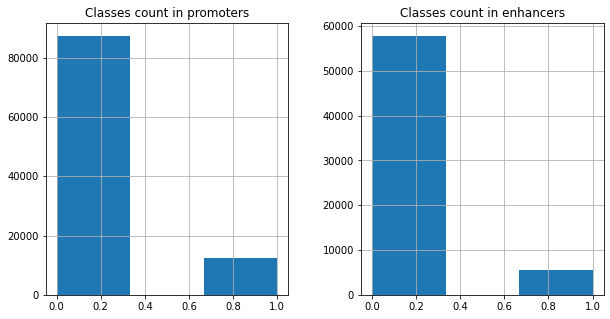

In [33]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

for axis, (region, y) in zip(axes.ravel(), labels.items()):
    y.hist(ax=axis, bins=3)
    axis.set_title(f"Classes count in {region}")
fig.show()

Fortunately this is not our case, as the imbalance is always better than $\frac{1}{10}$.

### Constant features
Sometimes we can encounter features with the same constant value. These features do not add any additional value for each sample, therefore we can drop them if we encounter them.

Constant features are generally rare, and more often a symptom of something wrong with the data itself.

In [34]:
def drop_constant_features(df:pd.DataFrame)->pd.DataFrame:
    """Return DataFrame without constant features."""
    return df.loc[:, (df != df.iloc[0]).any()]

In [35]:
for region, x in epigenomes.items():
    result = drop_constant_features(x)
    if x.shape[1] != result.shape[1]:
        print(f"Features in {region} were constant and had to be dropped!")
        epigenomes[region] = result
    else:
        print(f"No constant features were found in {region}!")

No constant features were found in promoters!
No constant features were found in enhancers!


#### Z-scoring
In statistics, the standard score is the number of standard deviations by which the value of a raw score is above or below the mean value of what is being observed or measured. Raw scores above the mean have positive standard scores, while those below the mean have negative standard scores. To apply a [Z-Scoring](https://en.wikipedia.org/wiki/Standard_score), or standard scaler, means to subtract the mean and divide by the standard deviation.

Here we are going to use an arguably better version of z-scoring, called robust scaler, since it makes use of [robust statistics](https://en.wikipedia.org/wiki/Robust_statistics) to deal with the outlier, by subtracting the median and dividing by the standard deviation between the [interquantile range](https://en.wikipedia.org/wiki/Interquartile_range) at the $0.25$ quantile and the $0.75$ quantile.

In [36]:
from sklearn.preprocessing import RobustScaler

def robust_zscoring(df:pd.DataFrame)->pd.DataFrame:
    return pd.DataFrame(
        RobustScaler().fit_transform(df.values),
        columns=df.columns,
        index=df.index
    )

# Dictionary comprehension
epigenomes = {
    region: robust_zscoring(x)
    for region, x in epigenomes.items()
}

 ### Correlation with output
Another filter we can apply to our features is a correlation with the output labels. If our features do not have any kind of correlation with the output, we can consider dropping them.

We will start with testing monotonic and linear correlatios using the Spearman and Pearson tests respectively, and then we will test the candidate features that still do not seem to be correlated with the output with a [Maximal Information-based Nonparametric Exploration](https://en.wikipedia.org/wiki/Maximal_information_coefficient). This last coefficient is particularly computationally heavvy to compute, so we will compute it only for the candidate features to drop.

#### Why the Pearson correlation test is not sufficient?
The Pearson correlation test is definitely a good test for most features, but does not capture non-linear relationships such as a XOR operation. For these cases a non-linear score such as MIC is required to avoid dropping meaningfull features that do not have a linear correlation.

In [37]:
p_value_threshold = 0.01
correlation_threshold = 0.05

In [38]:
uncorrelated = {
    region: set()
    for region in epigenomes
}

#### Linear correlations: The Pearson correlation coefficient
The Pearson correlation coefficient measures the linear relationship between two datasets. Strictly speaking, Pearson’s correlation requires that each dataset be normally distributed: we will be ignoring this aspect in the following test. Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply an exact linear relationship. Positive correlations imply that as x increases, so does y. Negative correlations imply that as x increases, y decreases.

The p-value roughly indicates the probability of an uncorrelated system producing datasets that have a Pearson correlation at least as extreme as the one computed from these datasets. The p-values are not entirely reliable but are probably reasonable for datasets larger than 500 or so.

We will computer the [Pearson correlation test](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) using [Scipy's pearsonr function](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pearsonr.html).

In [78]:
from scipy.stats import pearsonr

for region, x in epigenomes.items():
    for column in tqdm(x.columns, desc=f"Running Pearson test for {region}", dynamic_ncols=True, leave=False):
        correlation, p_value = pearsonr(x[column].values.ravel(), labels[region].values.ravel())
        if p_value > p_value_threshold:
            print(region, column, correlation, "pvalue", p_value)
            uncorrelated[region].add(column)

Running Pearson test for promoters:   0%|          | 0/422 [00:00<?, ?it/s]

Running Pearson test for enhancers:   0%|          | 0/420 [00:00<?, ?it/s]

#### Monotonic correlations: The Spearman correlation coefficient
The Spearman correlation is a nonparametric measure of the monotonicity of the relationship between two datasets. Unlike the Pearson correlation, the Spearman correlation does not assume that both datasets are normally distributed. Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply an exact monotonic relationship. Positive correlations imply that as x increases, so does y. Negative correlations imply that as x increases, y decreases.

The p-value roughly indicates the probability of an uncorrelated system producing datasets that have a Spearman correlation at least as extreme as the one computed from these datasets. The p-values are not entirely reliable but are probably reasonable for datasets larger than 500 or so.

We will compute the [Spearman correlation test](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) using [Scipy's spearmanr function](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.spearmanr.html).

In [40]:
from scipy.stats import spearmanr

for region, x in epigenomes.items():
    for column in tqdm(x.columns, desc=f"Running Spearman test for {region}", dynamic_ncols=True, leave=False):
        correlation, p_value = spearmanr(x[column].values.ravel(), labels[region].values.ravel())
        if p_value > p_value_threshold:
            print(region, column, correlation)
            uncorrelated[region].add(column)

Running Spearman test for promoters:   0%|          | 0/429 [00:00<?, ?it/s]

promoters RBM17 0.0017357903731259055
promoters TEAD2 0.006074816095685491


Running Spearman test for enhancers:   0%|          | 0/429 [00:00<?, ?it/s]

enhancers SUZ12 0.003725556821254994
enhancers U2AF2 0.008382526468374826
enhancers RBM17 0.0070468334718976474
enhancers FOXJ3 -0.003352037273159661
enhancers SRSF7 0.0005732572678956579
enhancers DLX4 0.001665525183300366
enhancers EWSR1 0.0024960090919305274
enhancers TSC22D4 0.01005433488312375
enhancers MCM7 0.010022400378152045


#### Non-linear correlations: The Maximal information coefficient

The [Maximal information coefficient](https://en.wikipedia.org/wiki/Maximal_information_coefficient) is a measure of the strength of the linear or non-linear association between two variables X and Y. As many other coefficients, has best results in datasets with a considerable amounts of samples (eg: at least more than 500).

Since computing non linear correlations is expensive computationally, we will only run the tests for the columns that are not linearly or monotonically correlated. We will then discard the columns that are not even non-linearly correlated with the output labels.

We compute the MIC score using [minepy](https://minepy.readthedocs.io/en/latest/index.html).

In [42]:
from minepy import MINE

for region, x in epigenomes.items():
    for column in tqdm(uncorrelated[region], desc=f"Running MINE test for {region}", dynamic_ncols=True, leave=False):
        mine = MINE()
        mine.compute_score(x[column].values.ravel(), labels[region].values.ravel())
        score = mine.mic()
        if score < correlation_threshold:
            print(region, column, score)
        else:
            uncorrelated[region].remove(column)

Running MINE test for promoters:   0%|          | 0/7 [00:00<?, ?it/s]

promoters ZNF408 0.005340002253433554
promoters THRAP3 0.004687910012842206
promoters SMARCA5 0.008086206466013452
promoters NCOA1 0.012069090810211135
promoters RBM17 0.01369666809770805
promoters TEAD2 0.00645255683403932
promoters NCOA4 0.0093035055146253


Running MINE test for enhancers:   0%|          | 0/9 [00:00<?, ?it/s]

enhancers DLX4 0.0032504806648413574
enhancers TSC22D4 0.003999125542364086
enhancers MCM7 0.004193966439679754
enhancers FOXJ3 0.005156709099396523
enhancers RBM17 0.005098695020370129
enhancers EWSR1 0.004269313108157713
enhancers U2AF2 0.0067433624260091005
enhancers SRSF7 0.004258522773314273
enhancers SUZ12 0.00736284746927227


#### Dropping features completely uncorrelated with output
We can now proceed to drop the features than are neither linearly, monotonically or non-linearly correlated with the output labels.

In [43]:
for region, x in epigenomes.items():
    epigenomes[region] =x.drop(columns=[
        col
        for col in uncorrelated[region]
        if col in x.columns
    ])

### Features correlations
Now we proceed to identify and drop features that have extremely high Pearson correlation scores (more than 0.95 or even 0.99) one-another. These features often do not add significant information when one is removed. If we have to choose to remove a feature, we will remove the one with lower [entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)).

While we run these tests we will also store the obtained scores to be able, afterwards, to visualize what does it mean for two features to have high or low correlation scores.

We will compute the entropy using [Scipy's entropy function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html).

In [44]:
p_value_threshold = 0.01
correlation_threshold = 0.95

In [45]:
from scipy.stats import spearmanr
from scipy.stats import entropy

extremely_correlated = {
    region: set()
    for region in epigenomes
}

scores = {
    region: []
    for region in epigenomes
}

for region, x in epigenomes.items():
    for i, column in tqdm(
        enumerate(x.columns),
        total=len(x.columns), desc=f"Running Pearson test for {region}", dynamic_ncols=True, leave=False):
        for feature in x.columns[i+1:]:
            correlation, p_value = pearsonr(x[column].values.ravel(), x[feature].values.ravel())
            correlation = np.abs(correlation)
            scores[region].append((correlation, column, feature))
            if p_value < p_value_threshold and correlation > correlation_threshold:
                print(region, column, feature, correlation)
                if entropy(x[column]) > entropy(x[feature]):
                    extremely_correlated[region].add(feature)
                else:
                    extremely_correlated[region].add(column)

Running Pearson test for promoters:   0%|          | 0/422 [00:00<?, ?it/s]

promoters RBFOX2 POLR2G 0.9632970639849392


Running Pearson test for enhancers:   0%|          | 0/420 [00:00<?, ?it/s]

enhancers TCF12 CBFA2T3 0.9517533601546021


#### Scatter plots
We will use [seaborn's pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html#seaborn.pairplot) method to visualize the most correlated and least correlated features detected using the Pearson coefficient.

We will start by sorting the obtained scores.

In [46]:
scores = {
    region:sorted(score, key=lambda x: np.abs(x[0]), reverse=True)
    for region, score in scores.items()
}

We will start by considering the 3 most correlated touples.

Most correlated features from promoters epigenomes


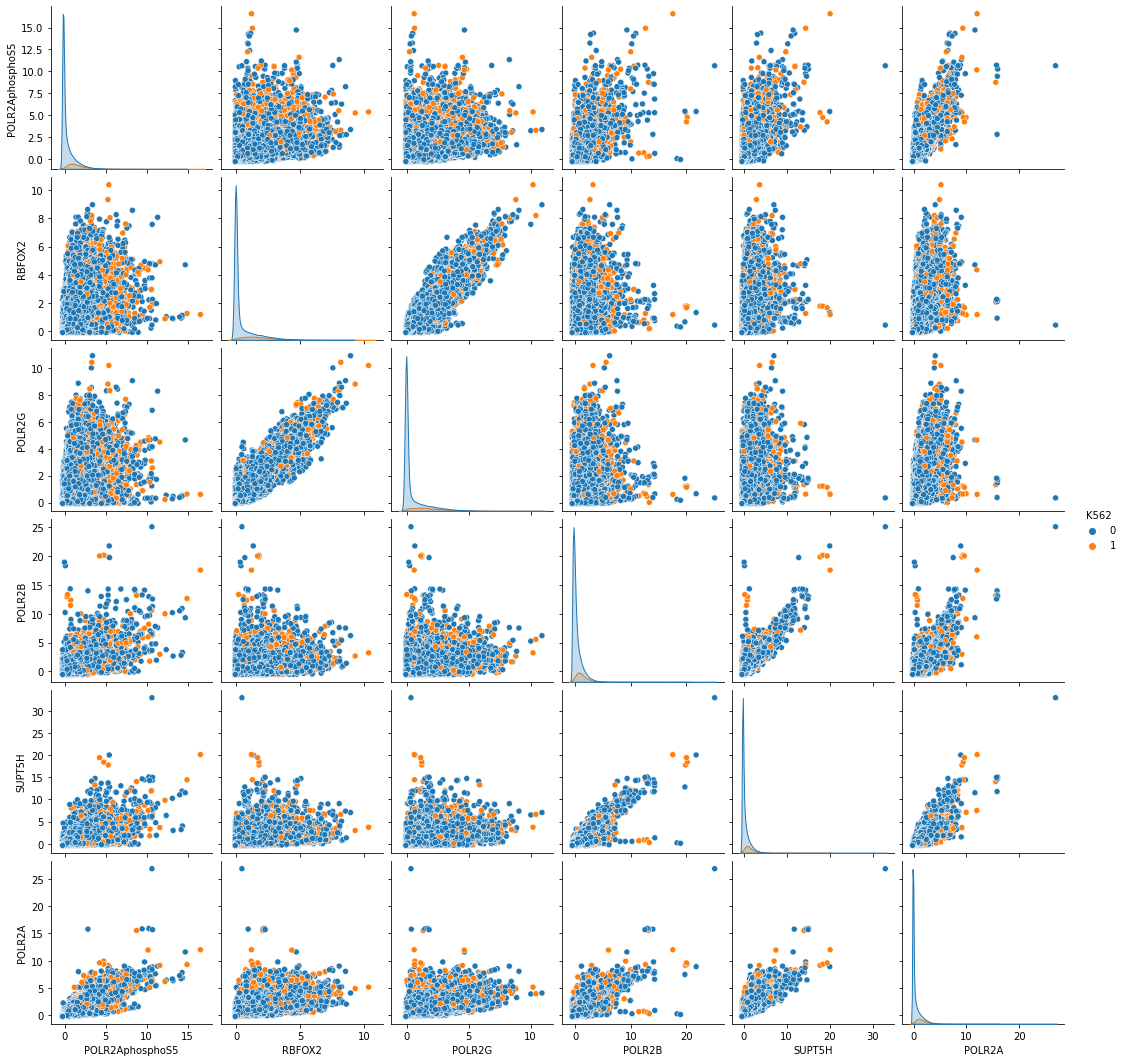

Most correlated features from enhancers epigenomes


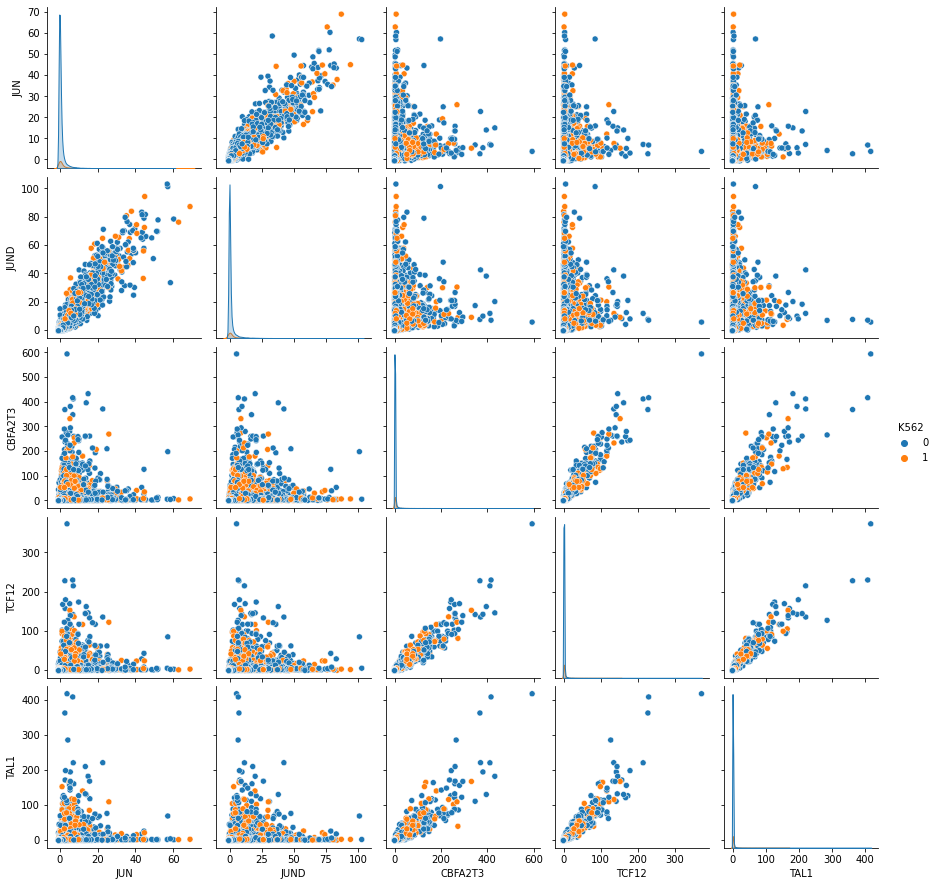

In [47]:
for region, x in epigenomes.items():
    _, firsts, seconds = list(zip(*scores[region][:3]))
    columns = list(set(firsts+seconds))
    print(f"Most correlated features from {region} epigenomes")
    sns.pairplot(pd.concat([
        x[columns],
        labels[region],
    ], axis=1), hue=labels[region].columns[0])
    plt.show()

We will start by considering the 3 most uncorrelated touples.

Least correlated features from promoters epigenomes


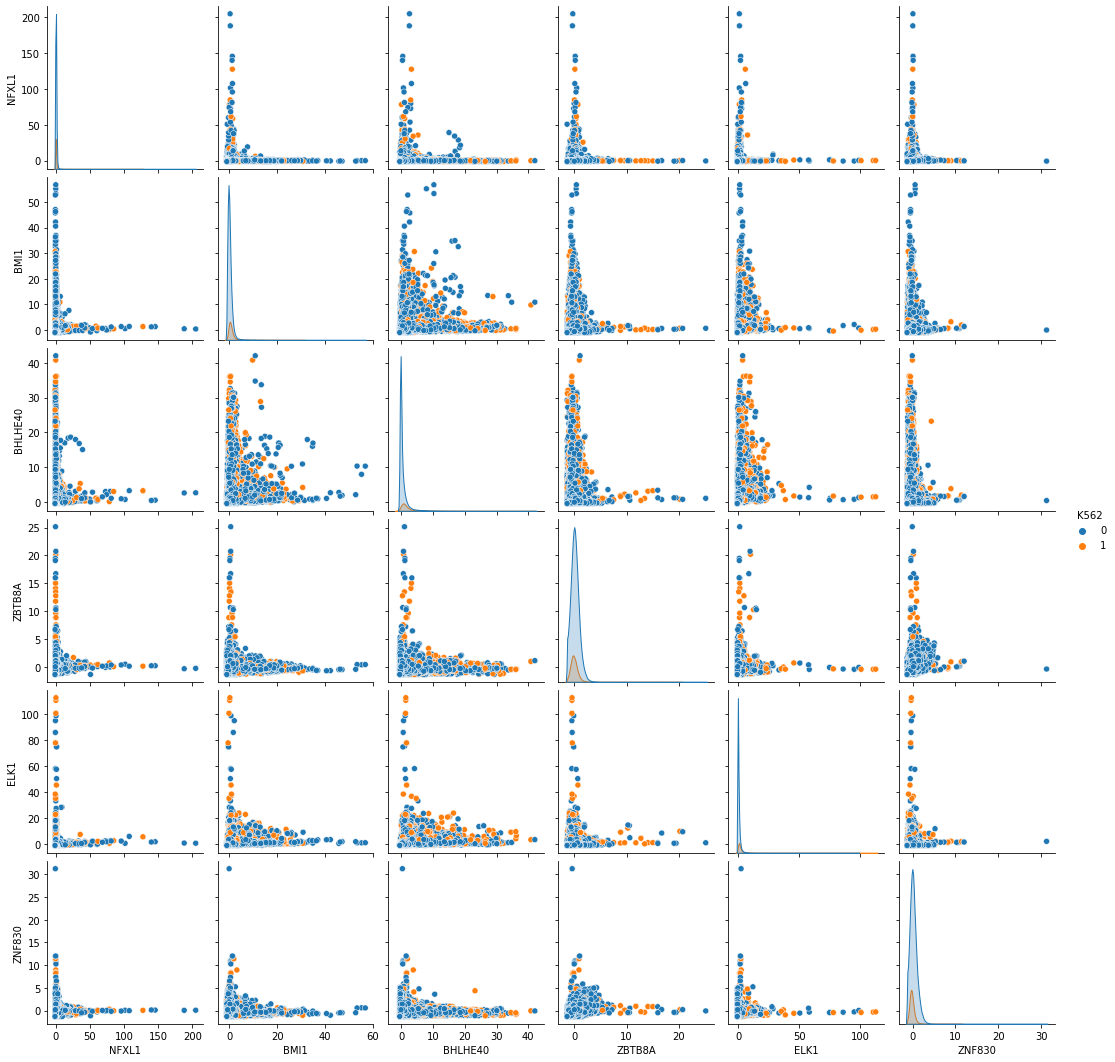

Least correlated features from enhancers epigenomes


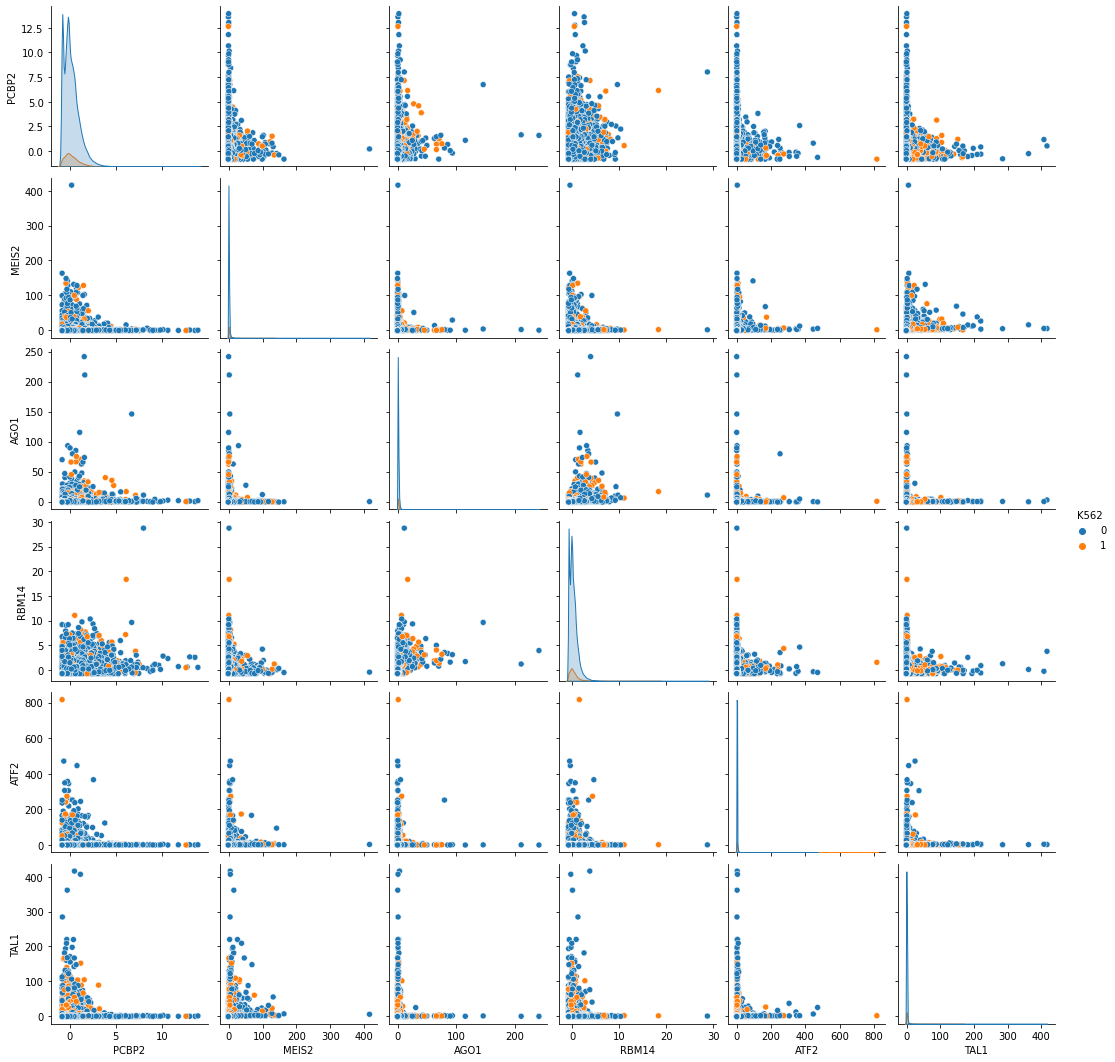

In [48]:
for region, x in epigenomes.items():
    _, firsts, seconds = list(zip(*scores[region][-3:]))
    columns = list(set(firsts+seconds))
    print(f"Least correlated features from {region} epigenomes")
    sns.pairplot(pd.concat([
        x[columns],
        labels[region],
    ], axis=1), hue=labels[region].columns[0])
    plt.show()

#### Features distributions
To visualize the distributions we will use histograms. Since we cannot show all distributions we select the top 10 most different features. We define the distance between the features using a pairwise euclidean distance.

To reduce the impact of outliers we filter outliers before the 0.01 percentile and the 0.99 percentile.

In [49]:
from sklearn.metrics.pairwise import euclidean_distances

In [50]:
def get_top_most_different(dist, n:int):
    return np.argsort(-np.mean(dist, axis=1).flatten())[:n]

Top 5 different features from promoters.


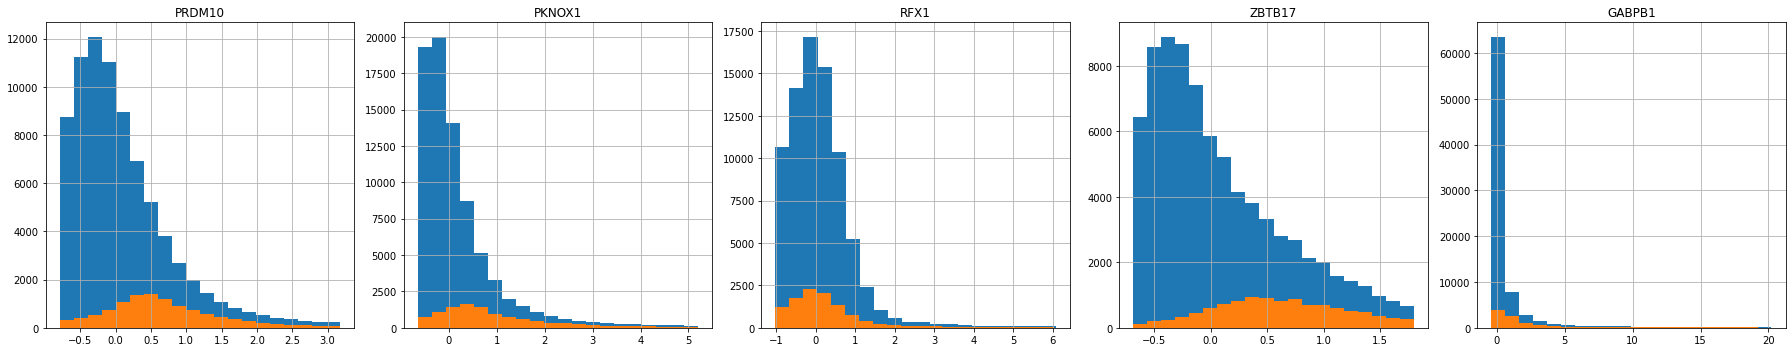

Top 5 different features from enhancers.


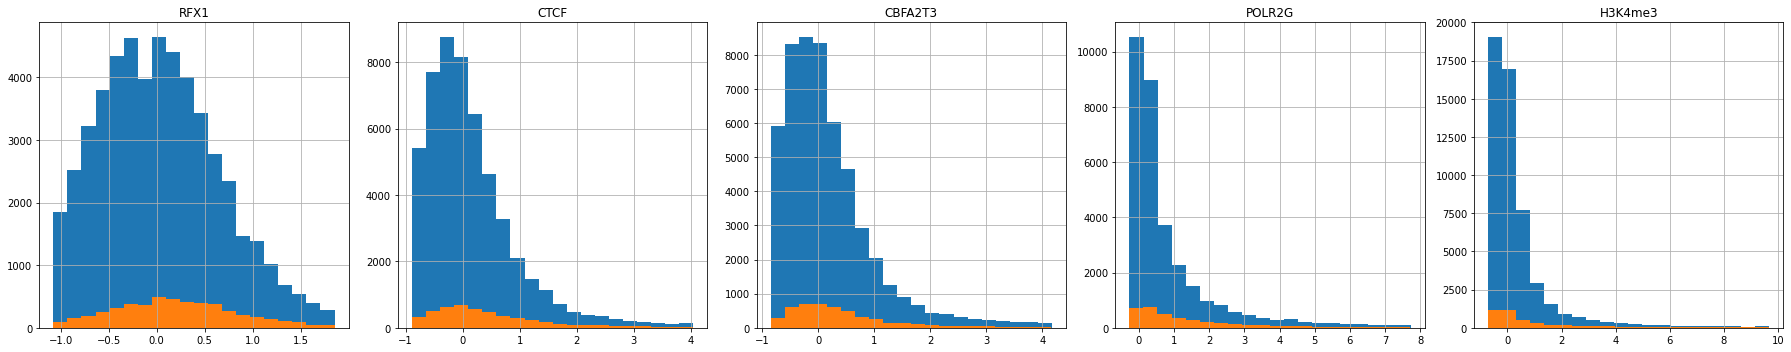

In [51]:
top_number = 5

for region, x in epigenomes.items():
    dist = euclidean_distances(x.T)
    most_distance_columns_indices = get_top_most_different(dist, top_number)
    columns = x.columns[most_distance_columns_indices]
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))
    print(f"Top {top_number} different features from {region}.")
    for column, axis in zip(columns, axes.flatten()):
        head, tail = x[column].quantile([0.05, 0.95]).values.ravel()
        
        mask = ((x[column] < tail) & (x[column] > head)).values
        
        cleared_x = x[column][mask]
        cleared_y = labels[region].values.ravel()[mask]
        
        cleared_x[cleared_y==0].hist(ax=axis, bins=20)
        cleared_x[cleared_y==1].hist(ax=axis, bins=20)

        axis.set_title(column)
    fig.tight_layout()
    plt.show()

Similarly, we will now visualize the tuples of distributions that are farter from one-another.

In [52]:
def get_top_most_different_tuples(dist, n:int):
    return list(zip(*np.unravel_index(np.argsort(-dist.ravel()), dist.shape)))[:n]

### Features selection with Boruta and Random Forests
In machine learning and statistics, [feature selection](https://en.wikipedia.org/wiki/Feature_selection), also known as variable selection, attribute selection or variable subset selection, is the process of selecting a subset of relevant features (variables, predictors) for use in model construction. The central premise when using a feature selection technique is that the data contains some features that are either redundant or irrelevant, and can thus be removed without incurring much loss of information.

There are numerous techniques for running feature selection. In this lesson we will use [Boruta](https://www.jstatsoft.org/article/view/v036i11), specifically the one made available through [BorutaPy](https://github.com/scikit-learn-contrib/boruta_py).

Boruta algorithm is a wrapper built around the random forest classification algorithm. The random forest
classification algorithm is relatively quick, can usually be run without tuning of parameters
and it gives a numerical estimate of the feature importance. It is an ensemble method in
which classification is performed by voting of multiple unbiased weak classifiers — decision
trees. These trees are independently developed on different bagging samples of the training
set. The importance measure of an attribute is obtained as the loss of accuracy of classification caused by the random permutation of attribute values between objects. 

Boruta is based on the same idea which forms the foundation of the random forest
classifier, namely, that by adding randomness to the system and collecting results from the
ensemble of randomized samples one can reduce the misleading impact of random fluctuations
and correlations.

In [56]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

def get_features_filter(X:pd.DataFrame, y:pd.DataFrame, name:str)->BorutaPy:
    boruta_selector = BorutaPy(
        RandomForestClassifier(n_jobs=cpu_count(), class_weight='balanced', max_depth=5),
        n_estimators='auto',
        verbose=2,
        alpha=0.05, # p_value
        max_iter=10, # In practice one would run at least 100-200 times
        random_state=42
    )
    boruta_selector.fit(X.values, y.values.ravel())
    return boruta_selector

filtered_epigenomes = {
    region:get_features_filter(
        X=x,
        y=labels[region],
        name=f"{cell_line}/{region}"
    ).transform(x.values)
    for region, x in tqdm(
        epigenomes.items(),
        desc="Running Baruta Feature estimation"
    )
}

Running Baruta Feature estimation:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration: 	1 / 10
Confirmed: 	0
Tentative: 	422
Rejected: 	0
Iteration: 	2 / 10
Confirmed: 	0
Tentative: 	422
Rejected: 	0
Iteration: 	3 / 10
Confirmed: 	0
Tentative: 	422
Rejected: 	0
Iteration: 	4 / 10
Confirmed: 	0
Tentative: 	422
Rejected: 	0
Iteration: 	5 / 10
Confirmed: 	0
Tentative: 	422
Rejected: 	0
Iteration: 	6 / 10
Confirmed: 	0
Tentative: 	422
Rejected: 	0
Iteration: 	7 / 10
Confirmed: 	0
Tentative: 	422
Rejected: 	0
Iteration: 	8 / 10
Confirmed: 	296
Tentative: 	126
Rejected: 	0
Iteration: 	9 / 10
Confirmed: 	296
Tentative: 	126
Rejected: 	0


BorutaPy finished running.

Iteration: 	10 / 10
Confirmed: 	296
Tentative: 	86
Rejected: 	0
Iteration: 	1 / 10
Confirmed: 	0
Tentative: 	420
Rejected: 	0
Iteration: 	2 / 10
Confirmed: 	0
Tentative: 	420
Rejected: 	0
Iteration: 	3 / 10
Confirmed: 	0
Tentative: 	420
Rejected: 	0
Iteration: 	4 / 10
Confirmed: 	0
Tentative: 	420
Rejected: 	0
Iteration: 	5 / 10
Confirmed: 	0
Tentative: 	420
Rejected: 	0
Iteration: 	6 / 10
Confirmed: 	0
T

## Data decomposition
With data decomposition we refer to the application of decomposition tecniques to reduce the high-dimensionality of datasets, partially reduce the impact of the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality).

In this section we will show how to use [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis), [MFA](https://en.wikipedia.org/wiki/Multiple_factor_analysis) and [TSNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) decomposition algorithms.

PCA is used to decompose a multivariate dataset in a set of successive orthogonal components that explain a maximum amount of the variance. Multiple factor analysis (MFA) is a factorial method devoted to the study of tables in which samples are described by a set of variables structured in groups. It may be seen as an extension of PCA when we consider quantitative variables, and an extension of [Multiple correspondence analysis (MCA)](https://en.wikipedia.org/wiki/Multiple_correspondence_analysis) when variables are qualitative.

Since we will apply MFA to the decomposition of one-hot encoded sequence data we will consider it as an extension of MCA, where the groups are the nucleotides.

Finally, T-distributed Stochastic Neighbor Embedding (t-SNE) is a machine learning algorithm for visualization [developed by Laurens van der Maaten and Geoffrey Hinton](http://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf). It is a nonlinear dimensionality reduction technique well-suited for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions. Specifically, it models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability.

#### PCA
Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. This transformation is defined in such a way that the first principal component has the largest possible variance (that is, accounts for as much of the variability in the data as possible), and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components. The resulting vectors (each being a linear combination of the variables and containing n observations) are an uncorrelated orthogonal basis set. PCA is sensitive to the relative scaling of the original variables: this is why we run BEFORE a z-scoring of the data.

PCA was invented back in 1901 by [Karl Pearson](https://en.wikipedia.org/wiki/Karl_Pearson) extending the work of [Francing Galton](https://en.wikipedia.org/wiki/Francis_Galton). These two men achieved great results in the field of biostatistics and are part of the reason the field exists at all.

Here we use [Sklearn's PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA).

In [57]:
from sklearn.decomposition import PCA

def pca(x:np.ndarray, n_components:int=2)->np.ndarray:
    return PCA(n_components=n_components, random_state=42).fit_transform(x)

#### TSNE
For the TSNE algorithm we show the usage of 3 different algorithms:

- [Sklearn's TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html), which is the slowest implementation but certainly the simplest to install on your computers. In fact, if you have installed the repository requirements you should already have this one available.
- [Ulyanov's TSNE multicore](https://github.com/DmitryUlyanov/Multicore-TSNE), better version that is around 10 times faster than the average execution of Sklearn's version. It requires the installation of cmake to run, and should be installed with the repository requirements.
- [Cannylab's TSNE GPU](https://github.com/CannyLab/tsne-cuda), the current state of the art version, faster than 1200 times Sklearn version and over 50 times faster than Ulyanov's version. This version is a bit harder to install if you [do not have Anaconda so please install it](https://www.anaconda.com/distribution/#download-section) but it is also possible to manually compile and install this TSNE version by [following the tutorial available in their repository Wiki](https://github.com/CannyLab/tsne-cuda/wiki/Installation). There is notably an error when using particularly low values of perplexity.

##### Note on preliminary use of PCA or MFA
Tipically when using TSNE on extremely high dimensional data (more than 50 dimensions) one should run, depending on the type of data, run a preliminary dimensionality reduction algorithm such as PCA or MFA depending on the type of data.

##### Is TSNE the right approach for my data?
The perplexity can be interpreted as a smooth measure of the effective number of neighbors. The
performance of SNE is fairly robust to changes in the perplexity, and typical values are between 5
and 50, but can be also much higher. If changing the value of perplexity changes significantly the output of the decomposition, TSNE might not be able to properly express the given data.

Therefore usually one should test various perplexity values before assuming that the TSNE decomposition obtained might actually visualize the data distribution. In this lesson we will consider perplexities of 30, 40, 50 and 100.

In [58]:
from sklearn.manifold import TSNE as STSNE

def sklearn_tsne(x:np.ndarray, perplexity:int, dimensionality_threshold:int=50):
    if x.shape[1] > dimensionality_threshold:
        x = pca(x, n_components=dimensionality_threshold)
    return STSNE(perplexity=perplexity, n_jobs=cpu_count(), random_state=42).fit_transform(x)

In [59]:
from MulticoreTSNE import MulticoreTSNE as UTSNE

def ulyanov_tsne(x:np.ndarray, perplexity:int, dimensionality_threshold:int=50, n_components:int=2):
    if x.shape[1] > dimensionality_threshold:
        x = pca(x, n_components=dimensionality_threshold)
    return UTSNE(n_components=n_components, perplexity=perplexity, n_jobs=cpu_count(), random_state=42, verbose=True).fit_transform(x)

In [60]:
from tsnecuda import TSNE as CTSNE

def cannylab_tsne(x:np.ndarray, perplexity:int, dimensionality_threshold:int=50):
    if x.shape[1] > dimensionality_threshold:
        x = pca(x, n_components=dimensionality_threshold)
    return CTSNE(perplexity=perplexity, random_seed=42).fit_transform(x)

ModuleNotFoundError: No module named 'tsnecuda'

## Data visualization

First we start by preparing all the data we are interested in visualizing.

In [65]:
tasks = {
    "x":[
        *[
            val.values
            for val in epigenomes.values()
        ],
        *[
            val.values
            for val in sequences.values()
        ],
        pd.concat(sequences.values()).values,
        pd.concat(sequences.values()).values,
    ],
    "y":[
        *[
            val.values.ravel()
            for val in labels.values()
        ],
        *[
            val.values.ravel()
            for val in labels.values()
        ],
        pd.concat(labels.values()).values.ravel(),
        np.vstack([np.ones_like(labels["promoters"]), np.zeros_like(labels["enhancers"])]).ravel(),
    ],
    "titles":[
        "Epigenomes promoters",
        "Epigenomes enhancers",
        "Sequences promoters",
        "Sequences enhancers",
        "Sequences active regions",
        "Sequences regions types",
        "Combined promoters data",
        "Combined enhancers data"
    ]
}

xs = tasks["x"]
ys = tasks["y"]
titles = tasks["titles"]

assert len(xs) == len(ys) == len(titles)

for x, y in zip(xs, ys):
    assert x.shape[0] == y.shape[0]

AssertionError: 

In [64]:
colors = np.array([
    "tab:blue",
    "tab:orange",
])

### Visualization using PCA

In [ ]:
from sklearn.decomposition import PCA

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(32, 16))

for x, y, title, axis in tqdm(zip(xs, ys, titles, axes.flatten()), desc="Computing PCAs", total=len(xs)):
    axis.scatter(*pca(x).T, s=1, color=colors[y])
    axis.xaxis.set_visible(False)
    axis.yaxis.set_visible(False)
    axis.set_title(f"PCA decomposition - {title}")
plt.show()

### TSNE

In [ ]:
for perpexity in tqdm((30, 40, 50, 100, 500, 5000), desc="Running perplexities"):
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(40, 20))
    for x, y, title, axis in tqdm(zip(xs, ys, titles, axes.flatten()), desc="Computing TSNEs", total=len(xs)):
        axis.scatter(*cannylab_tsne(x, perplexity=perpexity).T, s=1, color=colors[y])
        axis.xaxis.set_visible(False)
        axis.yaxis.set_visible(False)
        axis.set_title(f"TSNE decomposition - {title}")
    fig.tight_layout()
    plt.show()